GETTING URLS

In [ ]:
!pip install cnfg

In [ ]:
# load config file (engine ID and api key registered from Google API)
# config = {'api_key': 'XXXX', 'engine_ID': 'XXXX'}
url = '/Users/ĮČE beΔR/.googleapi_config'
config = cnfg.load(url)

In [ ]:
from apiclient.discovery import build
import cnfg
import pandas as pd
import time
from IPython import display

In [ ]:
# build a collection
service = build('customsearch', 'v1', developerKey=config['api_key'])
collections = service.cse()

In [ ]:
metal = ['metal can', 'crushed metal can', 'pet food can', 'paint can', 'soup can', 'aluminum foil', 'aluminum tray',
         'metal lid', 'metal wire hanger', 'metal pot', 'metal tool', 'metal curtain rod', 'license plate']
glass = ['glass jar', 'glass soda bottles']
plastic = ['plastic soda bottles', 'plastic water bottle', 'hard plastic water bottle', 'plastic milk jug',
           'plastic jar', 'plastic lid', 'plastic tupperware', 'plastic food container', 'plastic cookie insert',
           'plastic yogurt container', 'plastic dairy tub', 'plastic clamshell container',
           'plastic blister pack container', 'acetate box', 'plastic flower pot', 'plastic mixing bowl',
           'plastic crate', 'plastic bucket', 'plastic pail', 'plastic chair', 'plastic toy']
paper = ['carton food box', 'carton box', 'milk carton packaging', 'beverage carton packaging', 'carton drink box',
         'carton aseptic package', 'carton juice box', 'carton soup', 'newspaper', 'magazine', 'yellow pages',
         'mixed paper', 'white scrunched paper', 'lined paper', 'crumpled paper', 'sheet music', 'envelope',
         'paper receipt', 'paper bag', 'wrapping paper', 'paperback book', 'comic book', 'cardboard egg carton',
         'cardboard tray', 'cardboard shoe box', 'cardboard tube', 'paper file folders', 'cardboard packaging',
         'pizza box', 'cardboard sleeve', 'paper cup', 'corrugated cardboard']
recs = metal + glass + plastic + paper


nrplastic = ['candy wrapper', 'spiral binding', 'styrofoam container', 'styrofoam plate', 'styrofoam cup',
             'styrofoam tray', 'foam packing peanut', 'flexible plastic tube', 'lotion', 'toothpaste tubes',
             'cosmetics', 'basketball ball', 'bowling ball', 'soccer ball', 'american football ball', 'yoga ball',
             'plastic shopping bag']
nrglass = ['light bulb', 'mirror', 'glassware']
tanglers = ['cable', 'wire', 'cord', 'hose']
other = ['battery', 'printer cartridge', 'ceramic', 'cigarette lighter', 'gas lighter', 'cassette', 'VHS tape',
         'pen', 'marker']

nonrecs = nrplastic + nrglass + tanglers + other

In [ ]:
# query recyclables keywords to get URLs, image type, and caption
l = list()
for query in recs:
    for i in list(range(1, 100, 10)): # maximum 100 results
        try:
            request = collections.list(q=query, start=i, filter='1', # no duplicate results
                                       searchType='image', imgType='photo', imgColorType='color',
                                       cx=config['engine_ID'])
            time.sleep(1)
            response = request.execute()
            for image in response['items']:
                link = image['link']
                typ = image['mime']
                capt = image['title'].lower()
                l.append(dict(zip(['class', 'link', 'type', 'caption'], [query, link, typ, capt])))
                if i == 91: # store results in csv
                    images = pd.DataFrame(l)
                    images.to_csv('Recs.csv', mode='a', index=False, header=None)
                    l = list() # reset list and dataframe
                    images = pd.DataFrame()
            if i == 1: # checking progress at the start of each keyword
                display.clear_output()
                print(query)
        except:
            break

In [ ]:
# same for non-recyclables
l = list()
for query in nonrecs:
    for i in list(range(1, 100, 10)): # maximum 100 results
        try:
            request = collections.list(q=query, start=i, filter='1', # no duplicate results
                                       searchType='image', imgType='photo', imgColorType='color',
                                       cx=config['engine_ID'])
            time.sleep(1)
            response = request.execute()
            for image in response['items']:
                link = image['link']
                typ = image['mime']
                capt = image['title'].lower()
                l.append(dict(zip(['class', 'link', 'type', 'caption'], [query, link, typ, capt])))
                if i == 91: # store results in csv
                    images = pd.DataFrame(l)
                    images.to_csv('Nonrecs.csv', mode='a', index=False, header=None)
                    l = list() # reset list and dataframe
                    images = pd.DataFrame()
            if i == 1: # checking progress at the start of each keyword
                display.clear_output()
                print(query)
        except:
            break

In [ ]:
# deleting duplicate links and caption (same images sometimes have distinct links but same caption)
rdf = pd.read_csv('Recs.csv', names=sorted(['class', 'link', 'type', 'caption']))
rdf.drop_duplicates('link', inplace=True)
rdf.drop_duplicates('caption', inplace=True)

nrdf = pd.read_csv('Nonrecs.csv', names=sorted(['class', 'link', 'type', 'caption']))
nrdf.drop_duplicates('link', inplace=True)
nrdf.drop_duplicates('caption', inplace=True)

rdf.head()

In [ ]:
# classify items into materials
recsd = {'metal': metal, 'glass': glass, 'plastic': plastic, 'paper': paper}
nrecsd = {'glass': nrglass, 'plastic': nrplastic, 'tanglers': tanglers, 'other': other}

def rclassify(row):
    for key in recsd:
        if row['class'] in recsd[key]:
            return str(key)

rdf['class'] = rdf.apply(rclassify, axis=1)
rdf.head()

In [ ]:
def nrclassify(row):
    for key in nrecsd:
        if row['class'] in nrecsd[key]:
            return str(key)

nrdf['class'] = nrdf.apply(nrclassify, axis=1)
nrdf.head()

In [ ]:
# make directories for image files
import os
import sys
from urllib.request import urlretrieve as download

drs = ['recs_glass', 'recs_metal', 'recs_paper', 'recs_plastic',
       'nonrecs_glass', 'nonrecs_other', 'nonrecs_tanglers', 'nonrecs_plastic']

for i in drs:
    os.mkdir(os.path.join('./data/', i))

In [ ]:
# downloading images from urls
t = 0
for i in rdf.index:
    if t == 100:
        break
    try:
        download(rdf['link'][i], './data/{}_{}/{}-{}.jpg'.format('recs', rdf['class'][i],
                                                                  rdf['class'][i], i))
        time.sleep(1)
    except:
        continue
        t += 1

In [ ]:
from PIL import Image

for j in drs:
    for i in os.listdir(os.path.join('./data/', j)):
        p = os.path.join('./data/', j, i)
        try:
            Image.open(p)
        except:
            os.remove(p)

TRAINING TESTS

In [ ]:
import sys
import os

# pandas, numpy, matplotlib
import pandas as pd
% pylab inline
import seaborn as sns
sns.set()

# image processing imports
from PIL import Image
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import cv2

# keras imports
from keras.applications.vgg16 import VGG16
from keras.models import Model, load_model
from keras.layers.core import Flatten, Dense, Activation
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, image

import functools
from keras import backend as K
import tensorflow as tf
from tensorflow import metrics

# sklearn
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
# keras custom metrics for F1/2 and AUC
def true_pos(y_true, y_pred):
    return K.sum(y_true * K.round(y_pred)) + K.epsilon()
def false_pos(y_true, y_pred):
    return K.sum(y_true * (1. - K.round(y_pred))) + K.epsilon()
def false_neg(y_true, y_pred):
    return K.sum((1. - y_true) * K.round(y_pred)) + K.epsilon()
def precision(y_true, y_pred):
    return true_pos(y_true, y_pred) / (true_pos(y_true, y_pred) + false_pos(y_true, y_pred))
def recall(y_true, y_pred):
    return true_pos(y_true, y_pred) / (true_pos(y_true, y_pred) + false_neg(y_true, y_pred))
def f12(y_true, y_pred):
    return ((1 + (0.5 ** 2)) * precision(y_true, y_pred) * recall(y_true, y_pred)) / ((0.5 ** 2) * precision(y_true, y_pred) + recall(y_true, y_pred))

def as_keras_metric(method):
    @functools.wraps(method)
    def wrapper(self, args, **kwargs):
        value, update = method(self, args, **kwargs)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([update]):
            value = tf.identity(value)
        return value
    return wrapper
auc = as_keras_metric(metrics.auc)

In [ ]:
# use VGG16 as the base CNN and ...
vgg = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# ... retrain the top 4 convolution layers
for layer in vgg.layers[:-4]:
    layer.trainable = False

# add on custom dense layers
mod = vgg.output
mod = Flatten()(mod)
mod = Dense(1024, activation='relu')(mod)
mod = Dense(512, activation='relu')(mod)
mat = Dense(6, activation='softmax', name='class')(mod) # 2 final dense layers: 1 categorical output (materials)
rec = Dense(1, activation='sigmoid', name='recyc')(mod) # and 1 binary output (recyclable vs. non-recyclable)

# compile model
model = Model(inputs=vgg.input, outputs=[mat, rec])
model.compile(optimizer=Adam(lr=0.00001),
              loss={'recyc': 'binary_crossentropy', 'class': 'categorical_crossentropy'}, # 1 loss function for each output
              loss_weights={'recyc': 10, 'class': 1}, # arbitrary weights to counteract class imbalance
              metrics={'recyc': f12, 'class': auc}) # F1/2 weighs precision > recall, AUC works for imbalanced classes

model.summary()

In [ ]:
# create custom dataframe to manage multi-output data files while utilizing keras flow_from_directory
# code adapted from https://kapernikov.com/multi-label-classification-with-keras/
dr = './data'
mats = {'paper': 0, 'glass': 1, 'metal': 2, 'tanglers': 3, 'plastic': 4, 'other': 5}
recops = {'nonrecs': 0, 'recs': 1}

flist = []
tups = []
for dirpaths, dirnames, files in os.walk(dr):
    for file in files:
        if file.endswith('.jpg'):
            flist = os.path.join(dirpaths, file)
            lbs = os.path.basename(dirpaths).split('_') # make sure folder name follows 'recyc_material' convention
            zrecops = np.zeros(1, np.float32) # convert labels (folder name) into tensors
            if lbs[0] == 'recs':
                zrecops[0] = 1
            else: zrecops[0] = 0
            if lbs[1] in mats:
                zmats = np.zeros(len(mats), np.float32)
                zmats[mats[lbs[1]]] = 1
            tups.append((flist, np.concatenate((zmats, zrecops))))

img = pd.DataFrame(tups, columns=['path', 'outputs'])
img.head()

In [ ]:
# customize flow_from_directory to use its filenames and classes attributes
def df_flow(gen, df, **dflow_args):
    dgen = gen.flow_from_directory(dr, class_mode='sparse', shuffle=False, **dflow_args)
    dgen.filenames = df['path'].values
    dgen.classes = np.stack(df['outputs'].values)
    dgen.samples = len(df)
    dgen.n = len(df)
    dgen._set_index_array()
    dgen.directory = ''
    print('Found {} images'.format(dgen.n))
    return dgen

def split_outs(gen):
    while True:
        d = next(gen)
        x = d[0]
        y = [d[1][:, :6], d[1][:, 6:]] # split 1 tensor into 2 output tensors (1st-5th for materials and 6th for recyclability)
        yield x, y

In [ ]:
# train only a sample (increase sample size if trained with AWS)
img = img.sample(200)

# train-validate split 80/20 (split once more to get train-validate-test split)
imgtr = shuffle(img.sample(frac=0.8, random_state=1))
imgval = shuffle(img.drop(imgtr.index))

In [ ]:
# train with image augmentation, validate without
idgtr = ImageDataGenerator(rescale=1./255,
                           rotation_range=10,
                           width_shift_range=0.2,
                           height_shift_range=0.2,
                           shear_range=0.1,
                           zoom_range=0.2,
                           horizontal_flip=True)
idgval = ImageDataGenerator(rescale=1./255)

bsize = 10 # arbitrary, default 32
dgentr = df_flow(idgtr, imgtr, target_size=(224, 224), batch_size=bsize)
dgenval = df_flow(idgval, imgval, target_size=(224, 224), batch_size=bsize)

tr = split_outs(dgentr)
val = split_outs(dgenval)

In [ ]:
# training montage!
trsteps = dgentr.samples // bsize
valsteps = dgenval.samples // bsize

montage = model.fit_generator(tr, steps_per_epoch=trsteps,
                              epochs=2, # arbitrary, higher epochs more training time
                              validation_data=val,
                              validation_steps=valsteps)

In [ ]:
# save model
model.save('base_mod.h5')

In [ ]:
# visualize training history
htr = pd.DataFrame(montage.history)
htr['epoch'] = range(1, len(htr) + 1)

fig, ax = subplots(2, 2, figsize=(15, 10))
p1 = sns.regplot('epoch', 'class_auc', label='class AUC', data=htr, fit_reg=False, ax=ax[0, 0])
p2 = sns.regplot('epoch', 'val_class_auc', label='val class AUC', data=htr, fit_reg=False, ax=ax[0, 0])
p1.legend()

p1 = sns.regplot('epoch', 'recyc_f12', label='recyc F1/2', data=htr, fit_reg=False, ax=ax[0, 1])
p2 = sns.regplot('epoch', 'val_recyc_f12', label='val recyc F1/2', data=htr, fit_reg=False, ax=ax[0, 1])
p1.legend()

p1 = sns.regplot('epoch', 'class_loss', label='class loss', data=htr, fit_reg=False, ax=ax[1, 0])
p2 = sns.regplot('epoch', 'val_class_loss', label='val class loss', data=htr, fit_reg=False, ax=ax[1, 0])
p1.legend()

p1 = sns.regplot('epoch', 'recyc_loss', label='recyc loss', data=htr, fit_reg=False, ax=ax[1, 1])
p2 = sns.regplot('epoch', 'val_recyc_loss', label='val recyc loss', data=htr, fit_reg=False, ax=ax[1, 1])
p1.legend();

In [ ]:
# load model
model = load_model('./best_mod.h5', custom_objects={'auc': auc,
                                                    'recall': recall,
                                                    'f12': f12})

In [ ]:
# re-predict validation set
ypred = model.predict_generator(val, steps=valsteps, verbose=1)

# one-hot encode output tensors
yp = [np.argmax(ypred[0], axis=-1), np.round(ypred[1]).reshape(-1)]

In [ ]:
# list of true labels
yval = imgval.apply(lambda i: i['path'].split('/')[2].split('_'), axis=1, result_type='expand')
yval.columns = ['recyc', 'class']
yval = [np.array(yval['class'].apply(lambda i: mats[i])), np.array(yval['recyc'].apply(lambda i: recops[i]))]

In [ ]:
# confusion matrix for each output
fig, ax = subplots(1, 2, figsize=(15, 5))
p1 = sns.heatmap(confusion_matrix(yval[0], yp[0]), annot=True, fmt='g', vmin=0,
                 xticklabels=sorted(mats, key=mats.get), yticklabels=sorted(mats, key=mats.get),
                 cmap='RdYlBu', ax=ax[0])
p1.set_xlabel('predicted')
p1.set_ylabel('true')

p2 = sns.heatmap(confusion_matrix(yval[1], yp[1]), annot=True, fmt='g', vmin=0,
                 xticklabels=sorted(recops, key=recops.get), yticklabels=sorted(recops, key=recops.get),
                 cmap='RdYlBu', ax=ax[1]);
p2.set_xlabel('predicted')
p2.set_ylabel('true');

In [ ]:
# classification report for each output
print(classification_report(yval[0], yp[0], target_names=sorted(mats, key=mats.get)))
print(classification_report(yval[1], yp[1], target_names=sorted(recops, key=recops.get)))

In [ ]:
dmats = dict([(v, k) for k, v in mats.items()])
drecops = dict([(v, k) for k, v in recops.items()])

imgchk = pd.DataFrame()
imgchk['path'] = imgval['path']
imgchk['pred'] = [dmats[i] for i in yp[0]]
imgchk['true'] = [dmats[i] for i in yval[0]]

# visualizing specific mislabels
imgs = imgchk[(imgchk['true'] == 'plastic') & (imgchk['pred'] == 'paper')].sample(2).values # plastic mislabeled as paper?
for i in imgs:
    print('predicted :', i[1], '\t', 'true :', i[2])
    imgplot = plt.imshow(mpimg.imread(i[0]))
    plt.show()

In [ ]:
# code adapted from Deep Learning with Python by F. Chollet
rand = './data/recs_glass/'
p = rand + np.random.choice(os.listdir(rand))
imgplot = plt.imshow(mpimg.imread(p))
plt.show()

In [ ]:
_imgts = image.load_img(p, target_size=(224, 224))
_imgts = image.img_to_array(_imgts)
imgts = np.expand_dims(_imgts, axis=0)
imgts /= 255

In [ ]:
outs = [layer.output for layer in model.layers[1:-5]]
actmod = Model(inputs=model.input, outputs=outs)
acts = actmod.predict(imgts)
len(acts) # number of convolution layers

In [ ]:
nlayer = 0 # convolution layer number
nchannel = 0 # channel number (varies based on the layer number)
ts = acts[nlayer][0, :, :, nchannel]
Image.fromarray(np.uint8(plt.cm.viridis_r(ts) * 255))

In [ ]:
conv = model.get_layer('block5_pool') # get last convolution layer
grads = K.gradients(model.output, conv.output)[0]
pgrads = K.mean(grads, axis=(0, 1, 2))
itr = K.function([model.input], [pgrads, conv.output[0]])

In [ ]:
pgradsval, convval = itr([imgts])
for i in range(512):
    convval[:, :, i] *= pgradsval[i]
hmap = np.mean(convval, axis=-1)
hmap = np.maximum(hmap, 0)
hmap /= np.max(hmap)
hmap = cv2.resize(hmap, (_imgts.shape[1], _imgts.shape[0]))
hmap = np.uint8(255 * hmap)
hmap = cv2.applyColorMap(hmap, cv2.COLORMAP_JET)
imgs = hmap * 0.8 + _imgts * 255
image.array_to_img(imgs)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
==================================================================================================
input_2 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 224, 224, 64) 1792        input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 224, 224, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 112, 112, 64) 0           block1_conv2[0][0]               
__________________________________________________________________________________________________
block2_conv1 (Conv2D)           (None, 112, 112, 128 73856       block1_pool[0][0]                
__________________________________________________________________________________________________
block2_conv2 (Conv2D)           (None, 112, 112, 128 147584      block2_conv1[0][0]               
__________________________________________________________________________________________________
block2_pool (MaxPooling2D)      (None, 56, 56, 128)  0           block2_conv2[0][0]               
__________________________________________________________________________________________________
block3_conv1 (Conv2D)           (None, 56, 56, 256)  295168      block2_pool[0][0]                
__________________________________________________________________________________________________
block3_conv2 (Conv2D)           (None, 56, 56, 256)  590080      block3_conv1[0][0]               
__________________________________________________________________________________________________
block3_conv3 (Conv2D)           (None, 56, 56, 256)  590080      block3_conv2[0][0]               
__________________________________________________________________________________________________
block3_pool (MaxPooling2D)      (None, 28, 28, 256)  0           block3_conv3[0][0]               
__________________________________________________________________________________________________
block4_conv1 (Conv2D)           (None, 28, 28, 512)  1180160     block3_pool[0][0]                
__________________________________________________________________________________________________
block4_conv2 (Conv2D)           (None, 28, 28, 512)  2359808     block4_conv1[0][0]               
__________________________________________________________________________________________________
block4_conv3 (Conv2D)           (None, 28, 28, 512)  2359808     block4_conv2[0][0]               
__________________________________________________________________________________________________
block4_pool (MaxPooling2D)      (None, 14, 14, 512)  0           block4_conv3[0][0]               
__________________________________________________________________________________________________
block5_conv1 (Conv2D)           (None, 14, 14, 512)  2359808     block4_pool[0][0]                
__________________________________________________________________________________________________
block5_conv2 (Conv2D)           (None, 14, 14, 512)  2359808     block5_conv1[0][0]               
__________________________________________________________________________________________________
block5_conv3 (Conv2D)           (None, 14, 14, 512)  2359808     block5_conv2[0][0]               
__________________________________________________________________________________________________
block5_pool (MaxPooling2D)      (None, 7, 7, 512)    0           block5_conv3[0][0]               
__________________________________________________________________________________________________
flatten_2 (Flatten)             (None, 25088)        0           block5_pool[0][0]                
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 1024)         25691136    flatten_2[0][0]                  
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 512)          524800      dense_3[0][0]                    
__________________________________________________________________________________________________
class (Dense)                   (None, 6)            3078        dense_4[0][0]                    
__________________________________________________________________________________________________
recyc (Dense)                   (None, 1)            513         dense_4[0][0]                    
==================================================================================================
Total params: 40,934,215
Trainable params: 33,298,951
Non-trainable params: 7,635,264

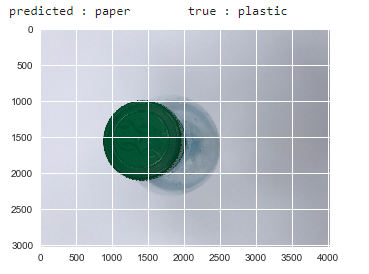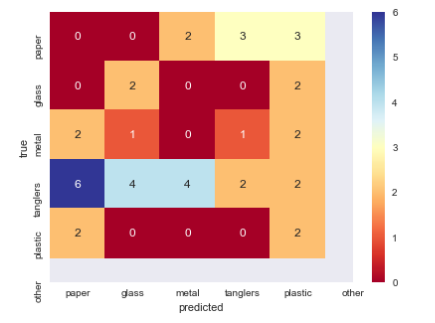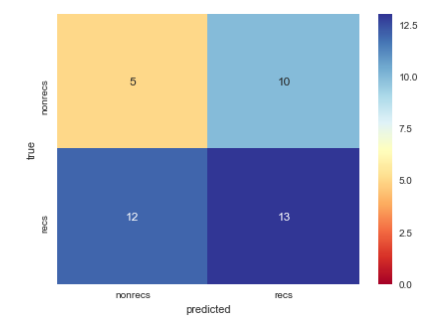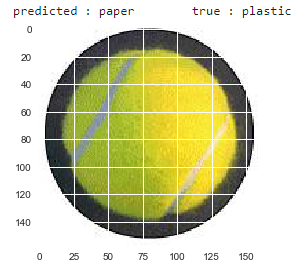
